In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [2]:
train = pd.read_csv("train.csv")

In [3]:
y = train['SalePrice']
train = train.drop('SalePrice',axis=1)

In [4]:
train.shape

(1460, 80)

In [5]:
output = {}

### NUMERICAL & CATEGORICAL SPLIT

In [6]:
numerical_columns = train.select_dtypes(['float','int'])
categorical_columns = train.select_dtypes('object')
output['numerical_columns'] = numerical_columns.columns
output['categorical_columns'] = categorical_columns.columns

### TREATING OUTLIER

In [7]:
numerical_outlier = {}

def treat_outlier(data,i):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    
    IQR = q3 - q1
    
    lower_range = q1 - 1.5 * IQR
    upper_range = q3 + 1.5 * IQR
    
    low_index = data[data<lower_range].index
    high_index = data[data>upper_range].index
        
    data[low_index] = lower_range
    data[high_index] = upper_range
    
    numerical_outlier[i] = [lower_range,upper_range]

            
    return data

In [8]:
for i in numerical_columns.columns:
    numerical_columns[i] = treat_outlier(numerical_columns[i],i)
output['Outlier_treatment'] = numerical_outlier

In [9]:
numerical_columns.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
1,2.0,20.0,80.0,9600.0,6.0,7.5,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,0.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,2.0,2006.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


In [10]:
(train['BsmtHalfBath']==1).sum()

80

In [11]:
(numerical_columns['BsmtHalfBath']==1).sum()

0

In [12]:
numerical_columns['BsmtHalfBath'] = train['BsmtHalfBath']
numerical_columns['KitchenAbvGr'] = train['KitchenAbvGr']

In [13]:
output['Replacing_column'] = ['BsmtHalfBath','KitchenAbvGr']

### DROPING HIGHLY UNIQUE COLUMNS

In [14]:
lst = []

for i in numerical_columns.columns:
    if(len(numerical_columns[i].unique()) >= 1400 or len(numerical_columns[i].unique())==1):
        lst.append(i)
        numerical_columns.drop(i,axis=1,inplace=True)
output['remove_high_unique'] = lst

### IMPUTING NAN VALUES WITH MEAN

In [15]:
column_wise_mean = {}

def mean_imputation_numeric(data,i):
    
    column_wise_mean[i] = data.mean()

    
    data = data.fillna(data.mean())
    return data

In [16]:
for i in numerical_columns.columns:
    numerical_columns[i] = mean_imputation_numeric(numerical_columns[i],i)
    
output['numerical_mean'] = column_wise_mean

### DROPING HIGHLY CORRELATED DATA

In [17]:
corr_matrix = numerical_columns.corr()
corr_matrix = corr_matrix.abs().unstack()
corr_matrix = corr_matrix.sort_values(ascending=False)
corr_matrix = corr_matrix[corr_matrix >= 0.8]
corr_matrix = corr_matrix[corr_matrix < 1]
corr_matrix = pd.DataFrame(corr_matrix).reset_index()
corr_matrix.columns = ['feature1', 'feature2', 'Correlation']

In [18]:
corr_matrix

,feature1,feature2,Correlation
0,GarageCars,GarageArea,0.894560
1,GarageArea,GarageCars,0.894560
2,GrLivArea,TotRmsAbvGrd,0.835192
3,TotRmsAbvGrd,GrLivArea,0.835192
4,TotalBsmtSF,1stFlrSF,0.807158
5,1stFlrSF,TotalBsmtSF,0.807158


In [19]:
numerical_columns.drop(['GarageArea','GarageYrBlt','GrLivArea','1stFlrSF'],axis=1,inplace=True)

output['drop_high_corr'] = ['GarageArea','GarageYrBlt','GrLivArea','1stFlrSF']

### NORMALIZATION

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
stand = StandardScaler()
temp = stand.fit_transform(numerical_columns)

output['normalization'] = stand

In [22]:
numerical_columns = pd.DataFrame(temp,columns=numerical_columns.columns)

In [23]:
numerical_columns.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,MoSold,YrSold
0,0.131067,-0.231964,-0.333244,0.652644,-0.564161,1.053246,0.878668,0.786624,0.614224,-0.958790,-0.488321,1.164283,1.111765,-0.241061,0.789741,1.227585,0.195307,-0.211454,0.981148,-0.957043,0.315946,-0.787243,0.350520,-1.599111,0.138777
1,-0.935733,0.609525,-0.013189,-0.073068,2.030907,0.156179,-0.429577,-0.670530,1.242296,-0.648290,0.532289,-0.796041,-0.821739,3.948809,0.789741,-0.761621,0.195307,-0.211454,-0.316385,0.608540,0.315946,1.768105,-0.811747,-0.489110,-0.614439
2,0.131067,-0.063666,0.446022,0.652644,-0.564161,0.986797,0.830215,0.533853,0.106224,-0.300716,-0.327437,1.191828,1.111765,-0.241061,0.789741,1.227585,0.195307,-0.211454,-0.316385,0.608540,0.315946,-0.787243,-0.011497,0.990891,0.138777
3,0.397766,-0.512461,-0.027104,0.652644,-0.564161,-1.870528,-0.720298,-0.670530,-0.517230,-0.055097,-0.739702,0.939328,1.111765,-0.241061,-1.026041,-0.761621,0.195307,-0.211454,0.332382,0.608540,1.662750,-0.787243,-0.144872,-1.599111,-1.367655
4,0.131067,0.833923,1.283733,1.378355,-0.564161,0.953572,0.733308,1.931531,0.496460,-0.170955,0.238172,1.621080,1.111765,-0.241061,0.789741,1.227585,1.512385,-0.211454,1.629914,0.608540,1.662750,0.859156,0.788753,2.100892,0.138777


### REPLACING OTHER NAN VALUES

In [24]:
categorical_columns.replace(['None','none','-','NONE'],np.nan,inplace=True)

In [25]:
categorical_columns.isnull().sum()

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

### DROPING HIGHLY NAN VALUES

In [26]:
categorical_columns.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1,inplace=True)

output['drop_high_nan'] = ['Alley','PoolQC','Fence','MiscFeature']

### TREATING MODERATE NAN VALUES

In [27]:
temp = categorical_columns[['FireplaceQu','MasVnrType']].fillna('none')

output['fill_with_nan'] = ['FireplaceQu','MasVnrType']

In [28]:
categorical_columns.drop(['FireplaceQu','MasVnrType'],axis=1,inplace=True)

In [29]:
categorical_columns = pd.concat([categorical_columns,temp],axis=1)

In [30]:
categorical_columns.isnull().sum()

MSZoning          0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
KitchenQual       0
Functional        0
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
PavedDrive        0
SaleType          0
SaleCondition     0
FireplaceQu       0
MasVnrType        0
dtype: int64

### MODE IMPUTATION ON CATEGORICAL DATA

In [31]:
categorical_mode = {}

def mode_imputation_categorical(lst,i):
    mode = lst.mode().iloc[0]
    
    categorical_mode[i]=mode

    df = lst.fillna(mode)
    return df

In [32]:
for i in categorical_columns.columns:
    categorical_columns[i] = mode_imputation_categorical(categorical_columns[i],i)
    
output['categorical_mode'] = categorical_mode

In [33]:
categorical_columns.isnull().sum()

MSZoning         0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
SaleType         0
SaleCondition    0
FireplaceQu      0
MasVnrType       0
dtype: int64

In [34]:
categorical_columns.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,FireplaceQu,MasVnrType
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,none,BrkFace
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,TA,none
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,TA,BrkFace
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml,Gd,none
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,TA,BrkFace


### CATEGORICAL COLUMN ENCODING

In [35]:
# def frequency_encoding_categorical(categorical_column):
#     encoder_dictionary = {}
    
#     for i in categorical_column.columns:
#         encoder_dictionary[i] = (categorical_column[i].value_counts()/len(categorical_column)).to_dict()
    
#     for i in categorical_column.columns:
#         categorical_column[i] = categorical_column[i].map(encoder_dictionary[i])
        
#     output['frequency_encoding'] = encoder_dictionary

#     return categorical_column

In [36]:
# categorical_columns = frequency_encoding_categorical(categorical_columns)

In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def label_encoding_categorical(data,i):
    data = pd.DataFrame(le.fit_transform(data),columns=[i])
    return data

In [38]:
train_encoded_categorical = pd.DataFrame()
# test_categorical_columns = pd.DataFrame()

for i in categorical_columns.columns:
    train_encoded_categorical = pd.concat([train_encoded_categorical,label_encoding_categorical(categorical_columns[i],i)],axis=1)
    
# for i in test_categorical.columns:
#     test_encoded_categorical = pd.concat([test_encoded_categorical,label_encoding_categorical(test_categorical[i],i)],axis=1)
    
train_encoded_categorical.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,FireplaceQu,MasVnrType
0,3,1,3,3,0,4,0,5,2,2,0,5,1,1,12,13,2,4,2,2,3,3,2,5,1,0,1,4,2,6,1,1,4,4,2,8,4,5,1
1,3,1,3,3,0,2,0,24,1,2,0,2,1,1,8,8,3,4,1,2,3,1,0,5,1,0,1,4,3,6,1,1,4,4,2,8,4,4,3
2,3,1,0,3,0,4,0,5,2,2,0,5,1,1,12,13,2,4,2,2,3,2,2,5,1,0,1,4,2,6,1,1,4,4,2,8,4,4,1
3,3,1,0,3,0,0,0,6,2,2,0,5,1,1,13,15,3,4,0,3,1,3,0,5,1,2,1,4,2,6,5,2,4,4,2,8,0,2,3
4,3,1,0,3,0,2,0,15,2,2,0,5,1,1,12,13,2,4,2,2,3,0,2,5,1,0,1,4,2,6,1,1,4,4,2,8,4,4,1


In [39]:
categorical_columns.shape

(1460, 39)

### DATA CONCAT

In [40]:
df = pd.concat([numerical_columns,train_encoded_categorical],axis=1)

In [41]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,MoSold,YrSold,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,FireplaceQu,MasVnrType
0,0.131067,-0.231964,-0.333244,0.652644,-0.564161,1.053246,0.878668,0.786624,0.614224,-0.958790,-0.488321,1.164283,1.111765,-0.241061,0.789741,1.227585,0.195307,-0.211454,0.981148,-0.957043,0.315946,-0.787243,0.350520,-1.599111,0.138777,3,1,3,3,0,4,0,5,2,2,0,5,1,1,12,13,2,4,2,2,3,3,2,5,1,0,1,4,2,6,1,1,4,4,2,8,4,5,1
1,-0.935733,0.609525,-0.013189,-0.073068,2.030907,0.156179,-0.429577,-0.670530,1.242296,-0.648290,0.532289,-0.796041,-0.821739,3.948809,0.789741,-0.761621,0.195307,-0.211454,-0.316385,0.608540,0.315946,1.768105,-0.811747,-0.489110,-0.614439,3,1,3,3,0,2,0,24,1,2,0,2,1,1,8,8,3,4,1,2,3,1,0,5,1,0,1,4,3,6,1,1,4,4,2,8,4,4,3
2,0.131067,-0.063666,0.446022,0.652644,-0.564161,0.986797,0.830215,0.533853,0.106224,-0.300716,-0.327437,1.191828,1.111765,-0.241061,0.789741,1.227585,0.195307,-0.211454,-0.316385,0.608540,0.315946,-0.787243,-0.011497,0.990891,0.138777,3,1,0,3,0,4,0,5,2,2,0,5,1,1,12,13,2,4,2,2,3,2,2,5,1,0,1,4,2,6,1,1,4,4,2,8,4,4,1
3,0.397766,-0.512461,-0.027104,0.652644,-0.564161,-1.870528,-0.720298,-0.670530,-0.517230,-0.055097,-0.739702,0.939328,1.111765,-0.241061,-1.026041,-0.761621,0.195307,-0.211454,0.332382,0.608540,1.662750,-0.787243,-0.144872,-1.599111,-1.367655,3,1,0,3,0,0,0,6,2,2,0,5,1,1,13,15,3,4,0,3,1,3,0,5,1,2,1,4,2,6,5,2,4,4,2,8,0,2,3
4,0.131067,0.833923,1.283733,1.378355,-0.564161,0.953572,0.733308,1.931531,0.496460,-0.170955,0.238172,1.621080,1.111765,-0.241061,0.789741,1.227585,1.512385,-0.211454,1.629914,0.608540,1.662750,0.859156,0.788753,2.100892,0.138777,3,1,0,3,0,2,0,15,2,2,0,5,1,1,12,13,2,4,2,2,3,0,2,5,1,0,1,4,2,6,1,1,4,4,2,8,4,4,1


In [42]:
df.shape

(1460, 64)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.30, random_state=101)

### FEATURE SELECTION USING RDECV

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import time

In [45]:
from sklearn.metrics import mean_absolute_error

In [43]:
start = time.time()
rfc = RandomForestRegressor(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10))
rfecv.fit(df, y)
end = time.time()

In [44]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [45]:
print((end - start)/60)

8.33474049170812


In [46]:
print(rfecv.n_features_)

50


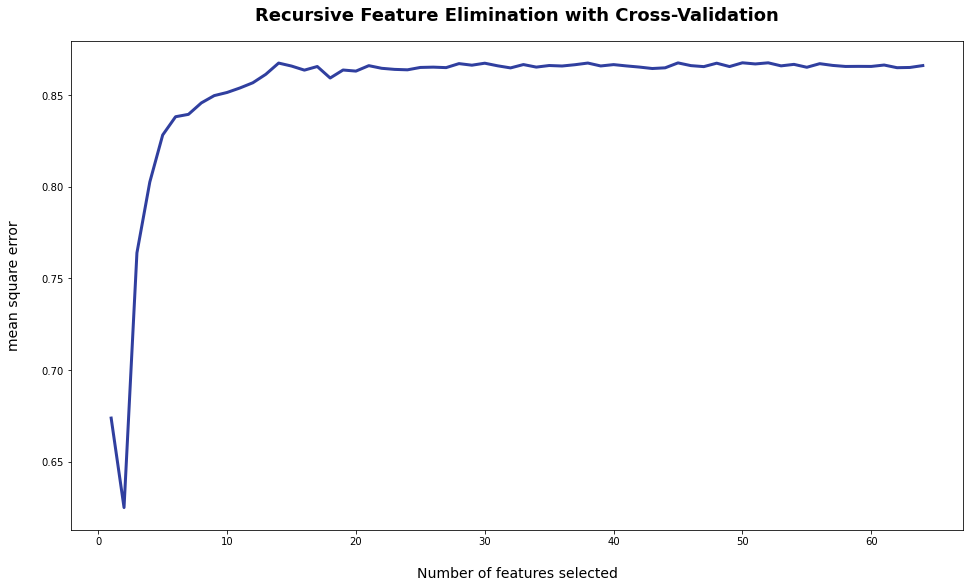

In [47]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('mean square error', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [48]:
rfecv.estimator_.feature_importances_

array([3.17219370e-03, 8.97800259e-03, 2.99072829e-02, 6.04915391e-01,
       4.59861432e-03, 9.03524910e-03, 8.93703366e-03, 7.15879019e-03,
       2.89442106e-02, 6.00149015e-03, 5.12082427e-02, 6.41466339e-02,
       1.07682905e-03, 3.93494609e-04, 2.20950916e-02, 2.20132305e-03,
       4.40418064e-03, 1.07630449e-02, 8.90753739e-03, 3.90580027e-02,
       8.42389874e-03, 6.78997074e-03, 5.39183722e-03, 1.72459012e-03,
       1.82563489e-03, 1.68954703e-03, 1.02963212e-03, 1.05877930e-03,
       1.28744919e-03, 9.30626432e-03, 8.98708713e-04, 1.09384956e-03,
       1.52763200e-03, 3.20997186e-03, 1.84602200e-03, 5.56937018e-03,
       8.96843009e-04, 4.42824695e-03, 2.47448129e-03, 1.41847036e-03,
       9.89328613e-04, 1.25124724e-03, 2.00009887e-03, 1.92796394e-03,
       2.61806790e-03, 4.70443310e-03, 1.46966662e-03, 1.66952658e-03,
       4.18846861e-03, 1.38736060e-03])

In [46]:
df.drop(df.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

NameError: name 'rfecv' is not defined

In [47]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,MoSold,YrSold,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,FireplaceQu,MasVnrType
0,0.131067,-0.231964,-0.333244,0.652644,-0.564161,1.053246,0.878668,0.786624,0.614224,-0.958790,-0.488321,1.164283,1.111765,-0.241061,0.789741,1.227585,0.195307,-0.211454,0.981148,-0.957043,0.315946,-0.787243,0.350520,-1.599111,0.138777,3,1,3,3,0,4,0,5,2,2,0,5,1,1,12,13,2,4,2,2,3,3,2,5,1,0,1,4,2,6,1,1,4,4,2,8,4,5,1
1,-0.935733,0.609525,-0.013189,-0.073068,2.030907,0.156179,-0.429577,-0.670530,1.242296,-0.648290,0.532289,-0.796041,-0.821739,3.948809,0.789741,-0.761621,0.195307,-0.211454,-0.316385,0.608540,0.315946,1.768105,-0.811747,-0.489110,-0.614439,3,1,3,3,0,2,0,24,1,2,0,2,1,1,8,8,3,4,1,2,3,1,0,5,1,0,1,4,3,6,1,1,4,4,2,8,4,4,3
2,0.131067,-0.063666,0.446022,0.652644,-0.564161,0.986797,0.830215,0.533853,0.106224,-0.300716,-0.327437,1.191828,1.111765,-0.241061,0.789741,1.227585,0.195307,-0.211454,-0.316385,0.608540,0.315946,-0.787243,-0.011497,0.990891,0.138777,3,1,0,3,0,4,0,5,2,2,0,5,1,1,12,13,2,4,2,2,3,2,2,5,1,0,1,4,2,6,1,1,4,4,2,8,4,4,1
3,0.397766,-0.512461,-0.027104,0.652644,-0.564161,-1.870528,-0.720298,-0.670530,-0.517230,-0.055097,-0.739702,0.939328,1.111765,-0.241061,-1.026041,-0.761621,0.195307,-0.211454,0.332382,0.608540,1.662750,-0.787243,-0.144872,-1.599111,-1.367655,3,1,0,3,0,0,0,6,2,2,0,5,1,1,13,15,3,4,0,3,1,3,0,5,1,2,1,4,2,6,5,2,4,4,2,8,0,2,3
4,0.131067,0.833923,1.283733,1.378355,-0.564161,0.953572,0.733308,1.931531,0.496460,-0.170955,0.238172,1.621080,1.111765,-0.241061,0.789741,1.227585,1.512385,-0.211454,1.629914,0.608540,1.662750,0.859156,0.788753,2.100892,0.138777,3,1,0,3,0,2,0,15,2,2,0,5,1,1,12,13,2,4,2,2,3,0,2,5,1,0,1,4,2,6,1,1,4,4,2,8,4,4,1


In [48]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [49]:
output['final_features'] = list(df.columns)

### CROSS VALIDATION

In [50]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [51]:
def model(model,x,y,score='neg_mean_absolute_error'):
    error = cross_val_score(model,x,y,cv=k_fold,n_jobs=1,scoring=score)
    return error

### MODEL BUILDING

In [52]:
#using linear regression
lr_error = model(LinearRegression(n_jobs=1),df,y)
lr_error

array([-2.28892254e+04, -2.36590358e+04, -1.70477126e+04, -1.94559583e+04,
       -7.46744313e+14, -1.89562564e+04, -1.98114055e+04, -1.93414657e+04,
       -1.96843749e+04, -1.86537554e+04])

In [53]:
#using random forest
rf_error = model(RandomForestRegressor(n_estimators=80,random_state=101),df,y)
rf_error

array([-15772.27594178, -21516.52106164, -17160.06267123, -15452.27885274,
       -21483.33484589, -17816.61618151, -18521.58724315, -17410.76369863,
       -17102.65085616, -17926.19392123])

In [54]:
#using gradient boosting
gb_error = model(GradientBoostingRegressor(),df,y)
gb_error

array([-17432.9955646 , -20144.72234783, -15657.7786999 , -15622.85491455,
       -19689.25370059, -18019.18464286, -16728.08725106, -15563.53927792,
       -14663.51292365, -15603.48259047])

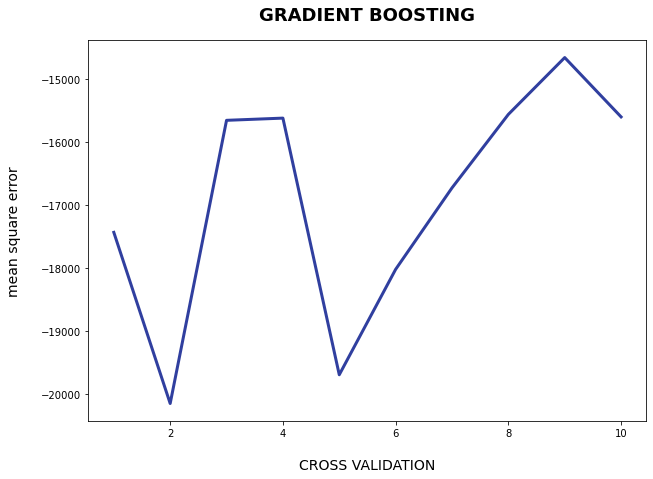

In [55]:
plt.figure(figsize=(10, 7))
plt.title('GRADIENT BOOSTING', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('CROSS VALIDATION', fontsize=14, labelpad=20)
plt.ylabel('mean square error', fontsize=14, labelpad=20)
plt.plot(range(1, len(gb_error) + 1), gb_error, color='#303F9F', linewidth=3)

plt.show()

In [56]:
#using xgboosting
xgb_error = model(XGBRegressor(),df,y)
xgb_error

array([-17191.27113656, -19430.46438891, -16462.09851241, -15564.83973673,
       -21477.37483947, -19070.8635488 , -18990.67626284, -18472.40822988,
       -16094.85356914, -16908.04275471])

In [59]:
help(SVR())

Help on SVR in module sklearn.svm._classes object:

class SVR(sklearn.base.RegressorMixin, sklearn.svm._base.BaseLibSVM)
 |  SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
 |  
 |  Epsilon-Support Vector Regression.
 |  
 |  The free parameters in the model are C and epsilon.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to datasets with more than a couple of 10000 samples. For large
 |  datasets consider using :class:`~sklearn.svm.LinearSVR` or
 |  :class:`~sklearn.linear_model.SGDRegressor` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  Read more in the :ref:`User Guide <svm_regression>`.
 |  
 |  Parameters
 |  ----------
 |  kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
 |       Specifies t

In [57]:
#using svm
svm_error = model(SVR(),df,y)
svm_error

array([-52711.15532794, -58358.22423717, -58270.4755827 , -48735.05544347,
       -58186.47277335, -67464.06857049, -59498.88880456, -53298.39120713,
       -52557.00399578, -46829.59593782])

### HYPERPARAMETER TUNING

In [61]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [62]:
param_test1 = {'n_estimators':range(10,81,5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,random_state=10), param_grid = param_test1, scoring='neg_mean_absolute_error',n_jobs=4, cv=5)
gsearch1.fit(df,y)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=10),
             n_jobs=4, param_grid={'n_estimators': range(10, 81, 5)},
             scoring='neg_mean_absolute_error')

In [63]:
gsearch1.best_params_

{'n_estimators': 80}

In [64]:
gsearch1.best_score_ 

-17605.43432455333

In [65]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80, random_state=10), param_grid = param_test2, scoring='neg_mean_absolute_error',n_jobs=4, cv=5)
gsearch2.fit(df,y)

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(n_estimators=80,
                                                 random_state=10),
             n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 200)},
             scoring='neg_mean_absolute_error')

In [66]:
gsearch2.best_params_

{'max_depth': 13, 'min_samples_split': 200}

In [67]:
best_model = GradientBoostingRegressor(learning_rate=0.1,n_estimators=80,max_depth=11,min_samples_split=200)
best_model.fit(df,y)
final_er = model(best_model,df,y)
final_er

array([-17021.12873438, -21267.58397517, -16735.34174025, -14953.64011215,
       -21036.73605691, -19400.53680338, -18184.70872282, -15746.23823616,
       -15051.13907451, -15169.98364056])

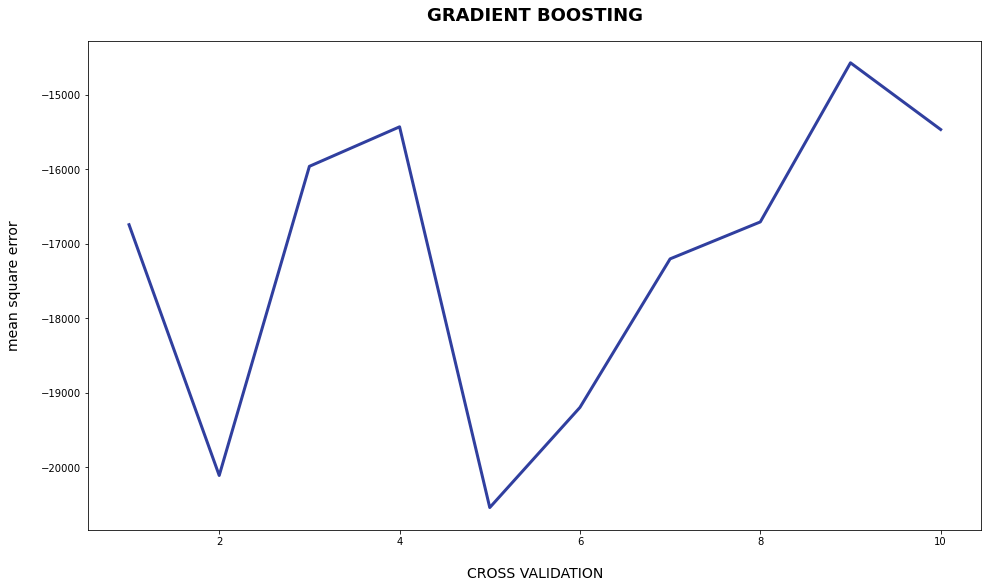

In [68]:
plt.figure(figsize=(16, 9))
plt.title('GRADIENT BOOSTING', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('CROSS VALIDATION', fontsize=14, labelpad=20)
plt.ylabel('mean square error', fontsize=14, labelpad=20)
plt.plot(range(1, len(gb_error) + 1), gb_error, color='#303F9F', linewidth=3)

plt.show()

In [69]:
round(final_er.sum()/len(final_er),2)

-17456.7

In [70]:
round(final_er.sum()/len(final_er),2)

-17456.7

In [71]:
output['model'] = best_model

In [72]:
output['Outlier_treatment'].pop('BsmtHalfBath')

output['Outlier_treatment'].pop('KitchenAbvGr')

[1.0, 1.0]

In [73]:
output

{'numerical_columns': Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'MoSold', 'YrSold'],
       dtype='object'),
 'categorical_columns': Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Bsmt

In [74]:
test = pd.read_csv('test.csv')

In [75]:
def prediction_model(test):
    test_numerical = test[output['numerical_columns']]

#     for i in output['Outlier_treatment'].keys():
#         q1 = test_numerical[i].quantile(0.25)
#         q3 = test_numerical[i].quantile(0.75)

#         IQR = q3 - q1

#         lower_range = q1 - 1.5 * IQR
#         upper_range = q3 + 1.5 * IQR

#         low_index = test_numerical[i][test[i]<lower_range].index
#         high_index = test_numerical[i][test[i]>upper_range].index

#         test_numerical[i][low_index] = output['Outlier_treatment'][i][0]
#         test_numerical[i][high_index] = output['Outlier_treatment'][i][1]

    test_numerical.drop(output['remove_high_unique'],axis=1,inplace=True)

    for i in output['numerical_mean'].keys():
        test_numerical[i].fillna(output['numerical_mean'][i],inplace=True)

    test_numerical.drop(output['drop_high_corr'],axis=1,inplace=True)

    temp = output['normalization'].fit_transform(test_numerical)

    test_numerical = pd.DataFrame(temp,columns=test_numerical.columns)

    test_categorical = test[output['categorical_columns']]

    test_categorical.replace(['None','none','-','NONE'],np.nan,inplace=True)

    test_categorical.drop(output['drop_high_nan'],axis=1,inplace=True)

    test_categorical[output['fill_with_nan']].fillna("null",inplace=True)

    for i in test_categorical.columns:
        test_categorical[i].fillna(output['categorical_mode'][i],inplace=True)

    for i in test_categorical.columns:
        test_categorical[i] = test_categorical[i].map(output['frequency_encoding'][i])

    test_categorical.head()

    dataset = pd.concat([test_numerical,test_categorical],axis=1)
    dataset.shape

    dataset = dataset[output['final_features']]
    dataset.shape

    GBmodel = output['model']
    GBmodel

    prediction = GBmodel.predict(dataset)
    
    return dataset,prediction

In [76]:
test_dataset,prediction = prediction_model(test)

In [77]:
submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": prediction
    })

In [78]:
submission

,Id,SalePrice
0,1461,120251.340943
1,1462,152873.587708
2,1463,173830.471672
3,1464,185621.930907
4,1465,191068.910333
...,...,...
1454,2915,86273.131621
1455,2916,82416.095325
1456,2917,191657.750774
1457,2918,124529.906369


In [79]:
submission.to_csv('submission.csv',index=False)

In [80]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,MoSold,YrSold,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageType,GarageFinish,SaleType,SaleCondition,FireplaceQu,MasVnrType
0,0.131067,-0.231964,-0.333244,0.652644,-0.564161,1.053246,0.878668,0.786624,0.614224,-0.958790,-0.488321,1.164283,1.111765,-0.241061,0.789741,1.227585,0.195307,0.981148,-0.957043,0.315946,-0.787243,0.350520,-1.599111,0.138777,0.788356,0.633562,0.897945,0.720548,0.946575,0.102740,0.863014,0.304795,0.781507,0.352740,0.345205,0.334247,0.443151,0.423288,0.678767,0.286301,0.886301,0.507534,0.934932,0.401370,0.651370,0.289041,0.867808,0.820548,0.472603,0.304795
1,-0.935733,0.609525,-0.013189,-0.073068,2.030907,0.156179,-0.429577,-0.670530,1.242296,-0.648290,0.532289,-0.796041,-0.821739,3.948809,0.789741,-0.761621,0.195307,-0.316385,0.608540,0.315946,1.768105,-0.811747,-0.489110,-0.614439,0.788356,0.633562,0.897945,0.032192,0.946575,0.007534,0.055479,0.497260,0.781507,0.150685,0.146575,0.620548,0.434247,0.423288,0.091781,0.150685,0.886301,0.507534,0.934932,0.503425,0.651370,0.289041,0.867808,0.820548,0.214384,0.597260
2,0.131067,-0.063666,0.446022,0.652644,-0.564161,0.986797,0.830215,0.533853,0.106224,-0.300716,-0.327437,1.191828,1.111765,-0.241061,0.789741,1.227585,0.195307,-0.316385,0.608540,0.315946,-0.787243,-0.011497,0.990891,0.138777,0.788356,0.331507,0.897945,0.720548,0.946575,0.102740,0.863014,0.304795,0.781507,0.352740,0.345205,0.334247,0.443151,0.423288,0.078082,0.286301,0.886301,0.507534,0.934932,0.401370,0.651370,0.289041,0.867808,0.820548,0.214384,0.304795
3,0.397766,-0.512461,-0.027104,0.652644,-0.564161,-1.870528,-0.720298,-0.670530,-0.517230,-0.055097,-0.739702,0.939328,1.111765,-0.241061,-1.026041,-0.761621,0.195307,0.332382,0.608540,1.662750,-0.787243,-0.144872,-1.599111,-1.367655,0.788356,0.331507,0.897945,0.180137,0.946575,0.034932,0.863014,0.304795,0.781507,0.141096,0.026027,0.620548,0.100000,0.469863,0.678767,0.150685,0.886301,0.165068,0.934932,0.401370,0.265068,0.469863,0.867808,0.069178,0.260274,0.597260
4,0.131067,0.833923,1.283733,1.378355,-0.564161,0.953572,0.733308,1.931531,0.496460,-0.170955,0.238172,1.621080,1.111765,-0.241061,0.789741,1.227585,1.512385,1.629914,0.608540,1.662750,0.859156,0.788753,2.100892,0.138777,0.788356,0.331507,0.897945,0.032192,0.946575,0.028082,0.863014,0.304795,0.781507,0.352740,0.345205,0.334247,0.443151,0.423288,0.151370,0.286301,0.886301,0.507534,0.934932,0.401370,0.651370,0.289041,0.867808,0.820548,0.214384,0.304795


In [81]:
GBmodel = output['model']
train_prediction = GBmodel.predict(df)

In [82]:
import sklearn.metrics

In [83]:
train_error = metrics.mean_absolute_error(y,train_prediction)
train_error

9238.956711150095

In [84]:
param_test1 = {'n_estimators':range(10,81,5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,random_state=10), param_grid = param_test1, scoring='neg_mean_absolute_error',n_jobs=4, cv=5)
gsearch1.fit(df,y)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=10),
             n_jobs=4, param_grid={'n_estimators': range(10, 81, 5)},
             scoring='neg_mean_absolute_error')

### RANDOM FOREST HYPERPARAMETER TUNING

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.30, random_state=101)

In [86]:
param_test1 = {'n_estimators':range(50,90,3)}
rf_search1 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_test1, scoring='neg_mean_absolute_error',n_jobs=4, cv=5)
rf_search1.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'n_estimators': range(50, 90, 3)},
             scoring='neg_mean_absolute_error')

In [87]:
rf_search1.best_params_

{'n_estimators': 83}

In [88]:
param_test2 = {'max_depth':range(2,50,2),'min_samples_split':range(200,1001,200)}
rf_search2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators=83), param_grid = param_test2, scoring='neg_mean_absolute_error',n_jobs=4, cv=5)
rf_search2.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_estimators=89), n_jobs=4,
             param_grid={'max_depth': range(2, 50, 2),
                         'min_samples_split': range(200, 1001, 200)},
             scoring='neg_mean_absolute_error')

In [89]:
rf_search2.best_params_

{'max_depth': 36, 'min_samples_split': 200}

In [90]:
rf_best_model = RandomForestRegressor(n_estimators=80,max_depth=50,min_impurity_split=200,)

In [91]:
rf_best_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=50, min_impurity_split=200, n_estimators=80)

In [92]:
te = rf_best_model.predict(X_test)

In [93]:
metrics.mean_absolute_error(y_test,te)

19428.588843362686